DeepDream is an artistic algorithm where a pretrained CNN is fed an image and optimized to amplify the features it "sees" in the image.

In [23]:
import tensorflow as tf

In [24]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

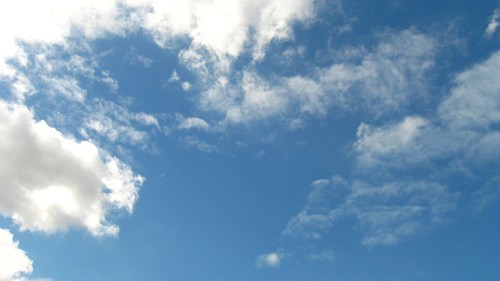

In [25]:
def download(file_path, max_dim=None):
    name = file_path.split('/')[-1]
    img = PIL.Image.open(file_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)
'''Function takes a file path as input, opens the image using PIL, and resizes it if max_dim is specified.
The function then converts the image to a NumPy array.'''


# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
image_path = '/content/sky1024px.jpg'
original_img = download(image_path, max_dim=500)
show(original_img)


## Prepare the feature extraction model

I have used  [InceptionV3](https://keras.io/api/applications/inceptionv3/) which is similar to the model originally used in DeepDream.

In [26]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The idea in DeepDream is modifying an input image to maximize the activation of specific neurons within the neural network. This results in visually interesting and sometimes surreal images. The key idea is to choose a layer (or layers) in the neural network and maximize the "loss" in a way that the image excites or activates those specific layers.

 There are 11  in InceptionV3, named 'mixed0' though 'mixed10'. Choice of layers in DeepDream determines the visual characteristics of the generated images. Lower layers(mixed0) capture simpler features, while deeper layers(mixed10) capture more complex and abstract features.

In [27]:
# Maximize the activations of these layers
names = ['mixed1', 'mixed0']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [28]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  #It expands the dimensions of the image tensor to create a batch of size 1.
  #Neural networks usually expect inputs in batch form, even if the batch size is 1.
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    # Calculate the mean activation value for each layer
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

This step involves calculating the gradients of the loss with respect to the input image, normalizing the gradients, and updating the image to enhance the patterns detected by the neural network.

In [29]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [30]:
deepdream = DeepDream(dream_model)

## Main Loop

In [31]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

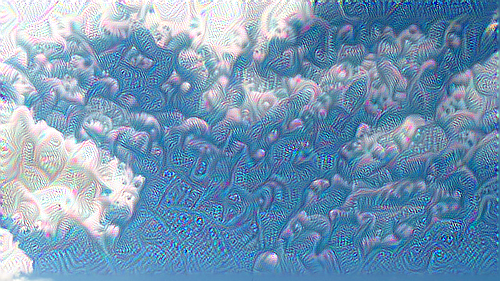

In [32]:

dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)

## Taking it up an octave

  



1.   Smooth out the output to reduce noise.
2.   Improve resolution and detail by applying DeepDream at different image sizes (octaves).
3.   Capture a broader range of features by incorporating patterns from different scales, allowing for more diverse and interesting visual results.


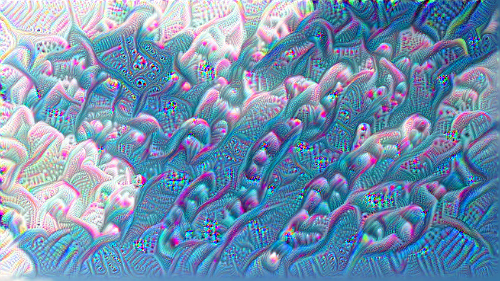

4.077469110488892

In [33]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [34]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

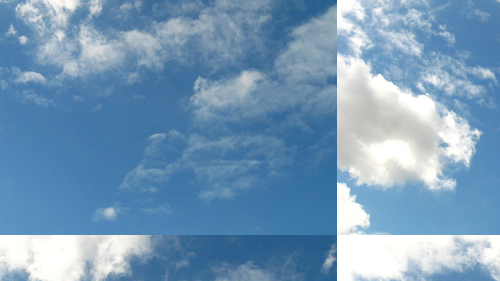

In [35]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [36]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [37]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation:

In [38]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

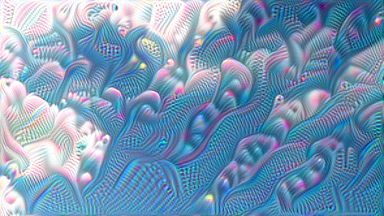

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)